# Predicting Student Academic Performance
Arshak Parsa

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import *
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [306]:
df = pd.read_csv("StudentsPerformance.csv")

nominal_var = ['gender', 'race/ethnicity', 'lunch', 'test preparation course']
ordinal_var = ['parental level of education']
numerical_var = ['reading score', 'writing score'] # except math score
len(nominal_var),len(ordinal_var),len(numerical_var)

df[nominal_var + ordinal_var] = df[nominal_var + ordinal_var].apply(lambda x: x.astype('category'))

# Task 1

In [307]:
print(df.head())
print(df.shape)
print(df.info())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
(1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null C

1000 samples and no missing data?! that's suspicious!


In [308]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Reading and writing scores are higher than math score, ... Understandable!

In [309]:
print(f"Total duplicated rows: {df.duplicated().sum()}")


Total duplicated rows: 0


1000 samples and no duplicated rows?! Hmmm...

This dataset feels synthetic! It's too much clean! Anyways...

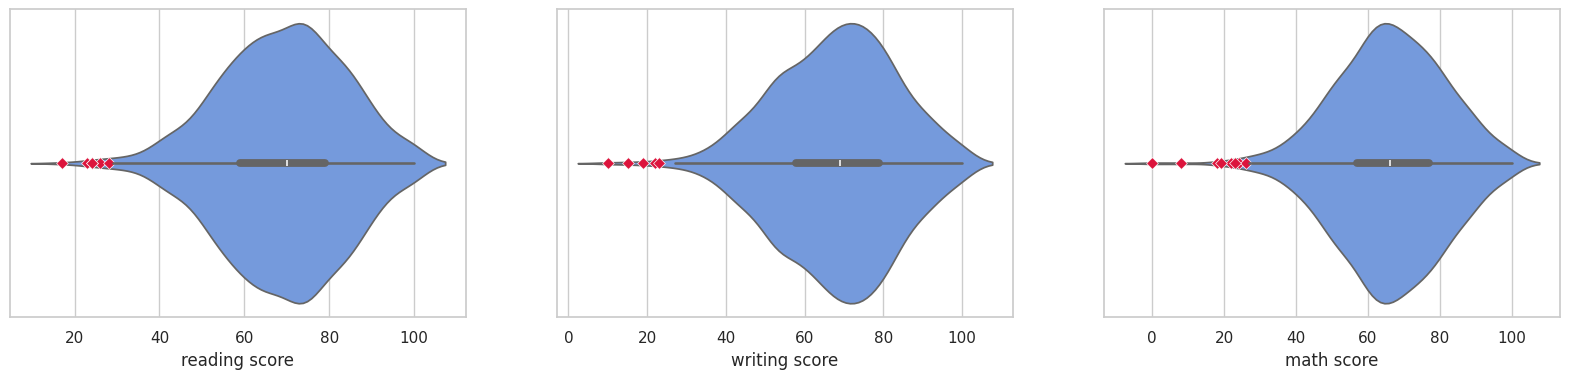

In [310]:
# Source - https://stackoverflow.com/questions/66913456/how-to-mix-the-outliers-from-boxplot-or-not-with-violin-plot
def custom_violinplot(d,ax,bw_adjust=1):
    q1, q3 = np.percentile(d, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    sns.violinplot(x=d, color='CornflowerBlue', ax=ax, bw_adjust=bw_adjust)
    outliers = d[(d > whisker_high) | (d < whisker_low)]
    if not outliers.empty:
        sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax)
    
    
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (20,4))
custom_violinplot(df['reading score'] ,axs[0])
custom_violinplot(df['writing score'] ,axs[1])
custom_violinplot(df['math score'] ,axs[2])

Nice and normal with a few outliers (probably backbenchers). 

Are you scared of outliers? Never remove them, a transformation might fix it.

No scaling is needed in my opinion since all three have a same range.

In [311]:
print(df.isnull().sum().sum())

0


No missing data as I have said before.

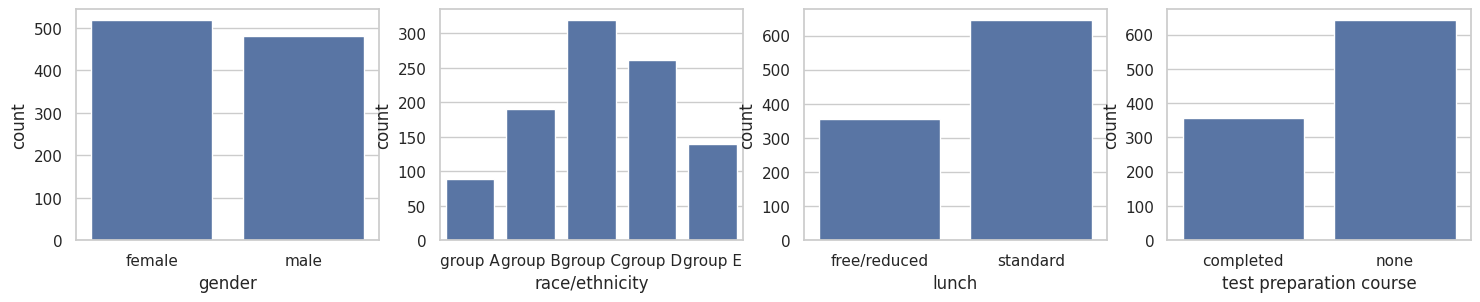

In [312]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize=(18, 3))
for i in range(4):
    sns.countplot(x=df[nominal_var[i]], ax = axs[i])

Race, lunch and TPC are not balanced, but .... Nice chart!

<Axes: xlabel='parental level of education', ylabel='count'>

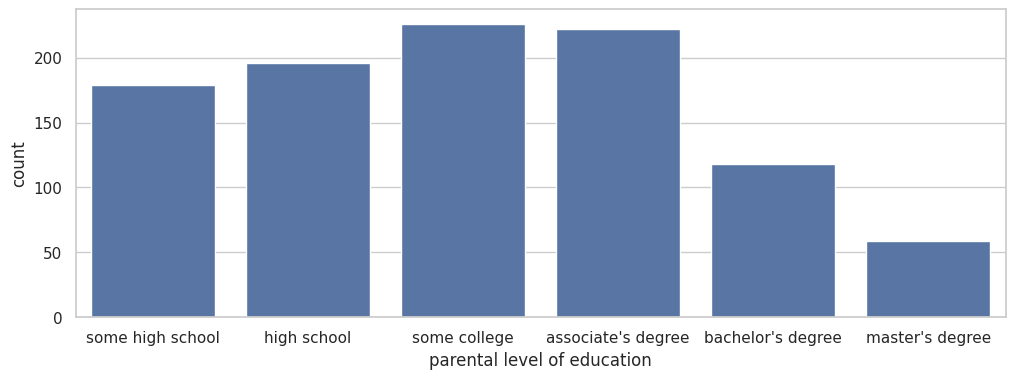

In [313]:
plt.figure(figsize=(12, 4))
order_edu = {
    'some high school' : 0,
    'high school' : 1,
    'some college' : 2,
    "associate's degree" : 3,
    "bachelor's degree" : 4,
    "master's degree" : 5
}
sns.countplot(x=df[ordinal_var[0]], order = order_edu)

No one likes to get a master's degree, ... Reasonable!

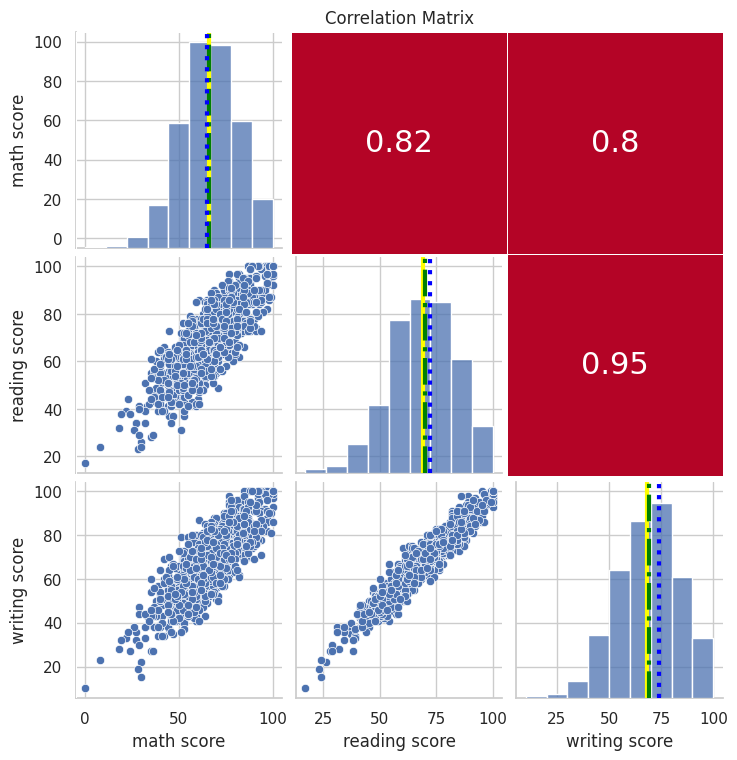

In [314]:
# Source - https://stackoverflow.com/a
# Posted by JohanC, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-11, License - CC BY-SA 4.0
# https://stackoverflow.com/questions/75289515/show-median-and-quantiles-on-seaborn-pairplot-python

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

def update_diag_func(data, label, color):
    plt.axvline(np.mean(data), color='yellow', linewidth=3.0)
    plt.axvline(np.median(data), color='green', linewidth=3.0, linestyle = '-.')
    plt.axvline(stats.mode(data).mode, color='blue', linewidth=3.0 , linestyle = ':')
    

def pairplot_heatmap(d1):
    e = sns.pairplot(d1, diag_kws = {'bins':9})

    e.map_diag(update_diag_func)
    e.map_upper(hide_current_axis)

    (xmin, _), (_, ymax) = e.axes[0, 0].get_position().get_points()
    (_, ymin), (xmax, _) = e.axes[-1, -1].get_position().get_points()

    ax = e.figure.add_axes([xmin, ymin, xmax - xmin, ymax - ymin], facecolor='none')

    corr1 = d1.corr()
    mask1 = np.tril(np.ones_like(corr1, dtype=bool))
    sns.heatmap(corr1, mask=mask1, cmap='coolwarm', vmax=.5, vmin=-.5,
                linewidths=.5, cbar=False, annot=True, annot_kws={'size': 22}, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    # ax.yaxis.tick_right()

    plt.title('Correlation Matrix')
    plt.show()

pairplot_heatmap(df.select_dtypes(['int64']))

You don't “correlate” with a nominal variable. Correlation only occurs among continuous variables. (I copied this from Reddit, LOL)

I shall say I **don't prefer** to plot and calculate correlation for nominal variables.

We have high correlation between all of them and that's understandable, if you have a high score in anything, there is a good chance that you have a high score in other things!

It's not cool to have highly correlated features since it causes multicollinearity but high correlation between features and the target variable (math score) is desired.

Let's create a preprocessor for ourself, shall we?

In [315]:
numerical_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('pre-transformer', FunctionTransformer(func = (lambda x: x+0.001), feature_names_out = 'one-to-one')), 
    ('transformer', PowerTransformer(method='box-cox')), # For handling outliers, it's enough...
])

nominal_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('encoder', OneHotEncoder())
])

ordinal_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('encoder', OrdinalEncoder(categories = [list(order_edu.keys())]))
])

preprocessor = Pipeline([
    ('column_trans', ColumnTransformer([
    ('num', numerical_pipeline, numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  ], verbose_feature_names_out=False)),
]) 


Let's test it

In [316]:
y = df['math score']

X = df.drop('math score', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.4,     
    random_state=5
)

y_transformer = PowerTransformer()

y_train_old, y_train = y_train.copy(), (pd.DataFrame(y_transformer.fit_transform(pd.DataFrame(y_train)), index = y_train.index, columns = ['math score (transformed)']))

print(f"Training set shape (X): {X_train.shape}")
print(f"Testing set shape (X): {X_test.shape}")

Training set shape (X): (600, 7)
Testing set shape (X): (400, 7)


In [317]:
X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out(), index = X_train.index)
X_train_preprocessed

,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none,parental level of education
278,1.190109,0.784456,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
561,0.302191,0.358087,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
994,-0.468928,-0.456836,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
697,0.158815,0.080676,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0
908,0.374388,0.218682,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,-1.066151,-0.123655,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
118,-0.468928,-0.522334,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
701,-0.193534,0.218682,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
206,-0.536846,-0.456836,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0


In [318]:
X_train

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
278,female,group C,some high school,free/reduced,none,86,80
561,female,group C,some college,standard,none,74,74
994,male,group A,high school,standard,none,63,62
697,female,group A,bachelor's degree,standard,none,72,70
908,female,group C,bachelor's degree,free/reduced,none,75,72
...,...,...,...,...,...,...,...
400,female,group C,some high school,standard,completed,54,67
118,female,group D,some high school,standard,none,63,61
701,female,group B,some high school,standard,none,67,72
206,male,group E,bachelor's degree,standard,none,62,62


In [319]:
preprocessor['column_trans']['num']['transformer'].lambdas_

array([1.34791526, 1.36296482])

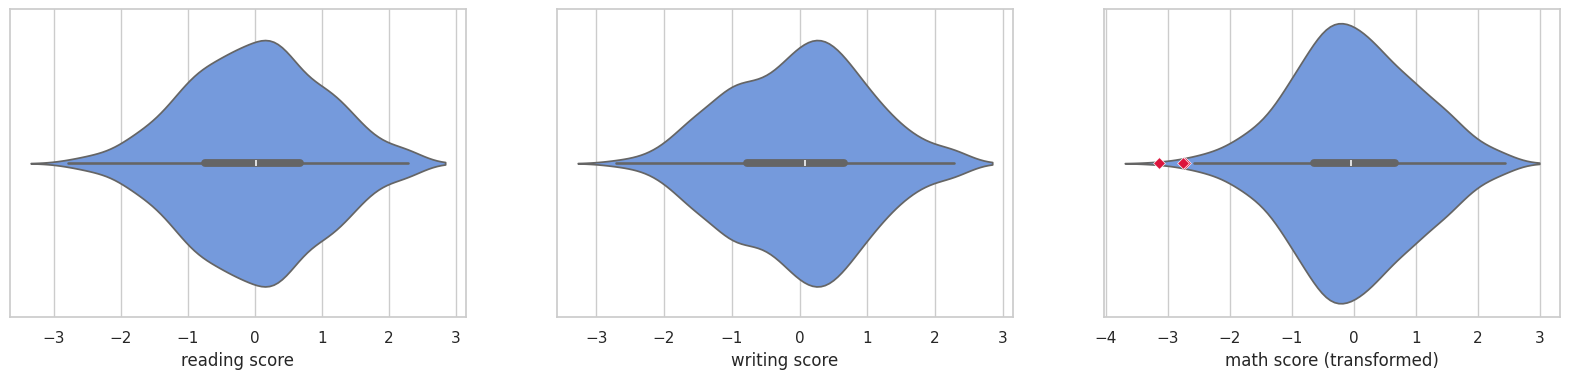

In [320]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (20,4))
custom_violinplot(X_train_preprocessed['reading score'] ,axs[0])
custom_violinplot(X_train_preprocessed['writing score'] ,axs[1])
custom_violinplot(y_train['math score (transformed)'] ,axs[2])

![](pic/pb.gif "segment")

No more outliers! It's not magic, it is called TRANSFORMATION 🗿🗿🗿.

(Ignore those two or three outliers, they are harmless!)

It's nice, isn't it? But look, it might make the interpretation of coefficients harder, so ... we might not use it for now, unless we get a very bad model.

Here is the formula of box cox

![](pic/box_cox.png)

I performed box cox because it is easier to interpret.

Lambdas are both positive which means box cox transformation is an increasing function.

I am pretty sure that we can interpret the coefficients just like how we interpret them in simple regression.


# Task 2

In [321]:
model = Pipeline([
    ('prep', Pipeline([
    ('column_trans', ColumnTransformer([  
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  
    ], verbose_feature_names_out=False , remainder= 'passthrough')), ]) ), # don't forget to set remainder to 'passthrough'
    ('regressor', LinearRegression())
])

model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X), columns = ["math score"])

print("\n--- Model Evaluation ---")

print(f"  R-squared (R²): {r2_score(y, y_pred):.4f}")

print(f"  Mean Absolute Error (MAE): {mean_absolute_error(y, y_pred):,.2f}")

print(f"  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y, y_pred)):,.2f}")


--- Model Evaluation ---
  R-squared (R²): 0.8762
  Mean Absolute Error (MAE): 4.25
  Root Mean Squared Error (RMSE): 5.33


This model looks good enough!

In [322]:
print("\n--- Model Parameters ---")
print(f"Intercept (b): {model['regressor'].intercept_:.4f}")

coefficients = pd.DataFrame(
    data=model['regressor'].coef_.T, 
    index=model['prep'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): 0.5822

Model Coefficients (w):
                                   Coefficient  Abs_Coefficient
gender_male                           6.626925         6.626925
gender_female                        -6.626925         6.626925
race/ethnicity_group E                3.886853         3.886853
test preparation course_none          1.764953         1.764953
test preparation course_completed    -1.764953         1.764953
lunch_standard                        1.612581         1.612581
lunch_free/reduced                   -1.612581         1.612581
race/ethnicity_group A               -1.288033         1.288033
race/ethnicity_group D               -1.161469         1.161469
race/ethnicity_group C               -1.044164         1.044164
writing score                         0.701900         0.701900
parental level of education          -0.417734         0.417734
race/ethnicity_group B               -0.393187         0.393187
reading score                  

Unfortunately sklearn does not provide a way for calculating p values and I don't have enough time for implementing it.

Starting with the coefficient of `writing score`, it's positive which means if you don't know how to write then how are you supposed to do math?! (It also had a high correlation with math when we plotted the heatmap)

Next we got `gender`, well that's understandable since most mathematicians are, ..., you know, MALE! Just look at this picture I found on the internet

![](pic/mathematicians.jpg)

Most of them are men (I should have included Maryam Mirzakhani though, but anyways).

I don't know anything about group E in ethnicity but it looks like they are very good at math (probably chinese).

I like chinese people though, they are very smart!

The coefficient of `test preparation course` is positive for `none`, which is a little weird because `test preparation course` is supposed to improve their score, I don't know, ANYWAYS!

The most influential variable here, seems like to be `Gender`, but let's see the coefficients of the model with transformation. 

In [323]:
model_t = Pipeline([
    ('prep', preprocessor),
    ('regressor', LinearRegression())
])

model_t.fit(X_train,y_train)

print("\n--- Model Parameters ---")
print(f"Intercept (b): {model_t['regressor'].intercept_[0]:.4f}")

coefficients = pd.DataFrame(
    data=model_t['regressor'].coef_.T, 
    index=model_t['prep'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): 0.0305

Model Coefficients (w):
                                   Coefficient  Abs_Coefficient
writing score                         0.663097         0.663097
gender_male                           0.441039         0.441039
gender_female                        -0.441039         0.441039
race/ethnicity_group E                0.330058         0.330058
reading score                         0.278465         0.278465
race/ethnicity_group A               -0.136365         0.136365
test preparation course_none          0.120847         0.120847
test preparation course_completed    -0.120847         0.120847
lunch_standard                        0.108395         0.108395
lunch_free/reduced                   -0.108395         0.108395
race/ethnicity_group C               -0.086061         0.086061
race/ethnicity_group D               -0.079901         0.079901
race/ethnicity_group B               -0.027732         0.027732
parental level of education    

You see, now the coefficient of writing is way higher. Something weird is going on ... maybe we shouldn't judge the coefficients with magnitude!

In [324]:
import statsmodels.api as sm

# Fit the OLS model
model_stats = sm.OLS(y, sm.add_constant(pd.DataFrame(model['prep'].transform(X), columns = model['prep'].get_feature_names_out()))).fit()

# Print the summary of the model
print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:             math score   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     700.2
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:47:37   Log-Likelihood:                -3092.6
No. Observations:                1000   AIC:                             6207.
Df Residuals:                     989   BIC:                             6261.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

The coefficients are a little bit different but at least we have p values here.

So according to this , gender is a significant feature. Also, `lunch` is another significant feature which we didn't notice.

OK enough interpretation, let's move on.

Text(0, 0.5, 'residual')

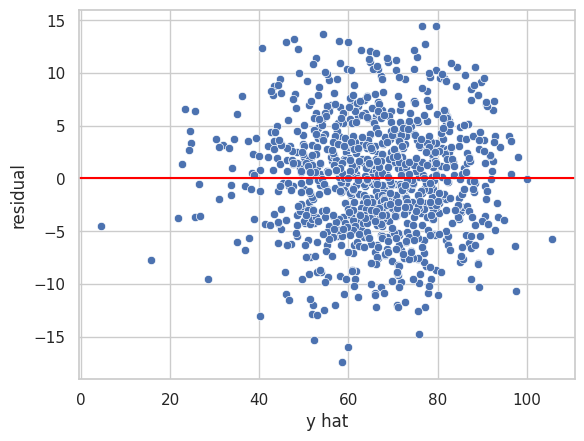

In [325]:
sns.scatterplot(x =y_pred['math score'], y = y - y_pred['math score'])
plt.axhline(0, color='red')
plt.xlabel('y hat')
plt.ylabel('residual')

<Axes: xlabel='math score', ylabel='Count'>

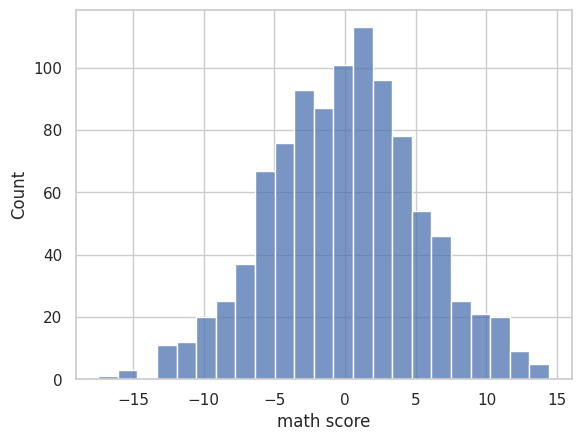

In [326]:
sns.histplot(y - y_pred['math score'])

No pattern, no increasing variance, residuals look normal, everything looks great here :)

# Task 3

In [327]:
model = Pipeline([
    ('prep', Pipeline([
    ('column_trans', ColumnTransformer([  
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  
    ], verbose_feature_names_out=False , remainder= 'drop')), ]) ),
    ('regressor', LinearRegression())
])

model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X), columns = ["math score"])

print("\n--- Model Evaluation ---")

print(f"  R-squared (R²): {r2_score(y, y_pred):.4f}")

print(f"  Mean Absolute Error (MAE): {mean_absolute_error(y, y_pred):,.2f}")

print(f"  Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y, y_pred)):,.2f}")


--- Model Evaluation ---
  R-squared (R²): 0.2513
  Mean Absolute Error (MAE): 10.59
  Root Mean Squared Error (RMSE): 13.11


Just removing 2 variables ruined the performance.

In [328]:
print("\n--- Model Parameters ---")
print(f"Intercept (b): {model['regressor'].intercept_:.4f}")

coefficients = pd.DataFrame(
    data=model['regressor'].coef_.T, 
    index=model['prep'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): 61.9393

Model Coefficients (w):
                                   Coefficient  Abs_Coefficient
race/ethnicity_group E                6.169950         6.169950
lunch_free/reduced                   -5.449725         5.449725
lunch_standard                        5.449725         5.449725
race/ethnicity_group A               -3.948115         3.948115
test preparation course_completed     2.809733         2.809733
test preparation course_none         -2.809733         2.809733
gender_male                           2.474584         2.474584
gender_female                        -2.474584         2.474584
race/ethnicity_group B               -2.058442         2.058442
parental level of education           1.666246         1.666246
race/ethnicity_group C               -1.572589         1.572589
race/ethnicity_group D                1.409196         1.409196


Now `test preparation course_completed` is opposite and gender is not the biggest coefficient.

OK, this model sucks, I don't see anything else, let's move on.

# Task 4

We can't do polynomial, since all numerical features we got are reading and writing scores.

We can do interactions but I don't have any hope for that.

Let's inspect the data a little more

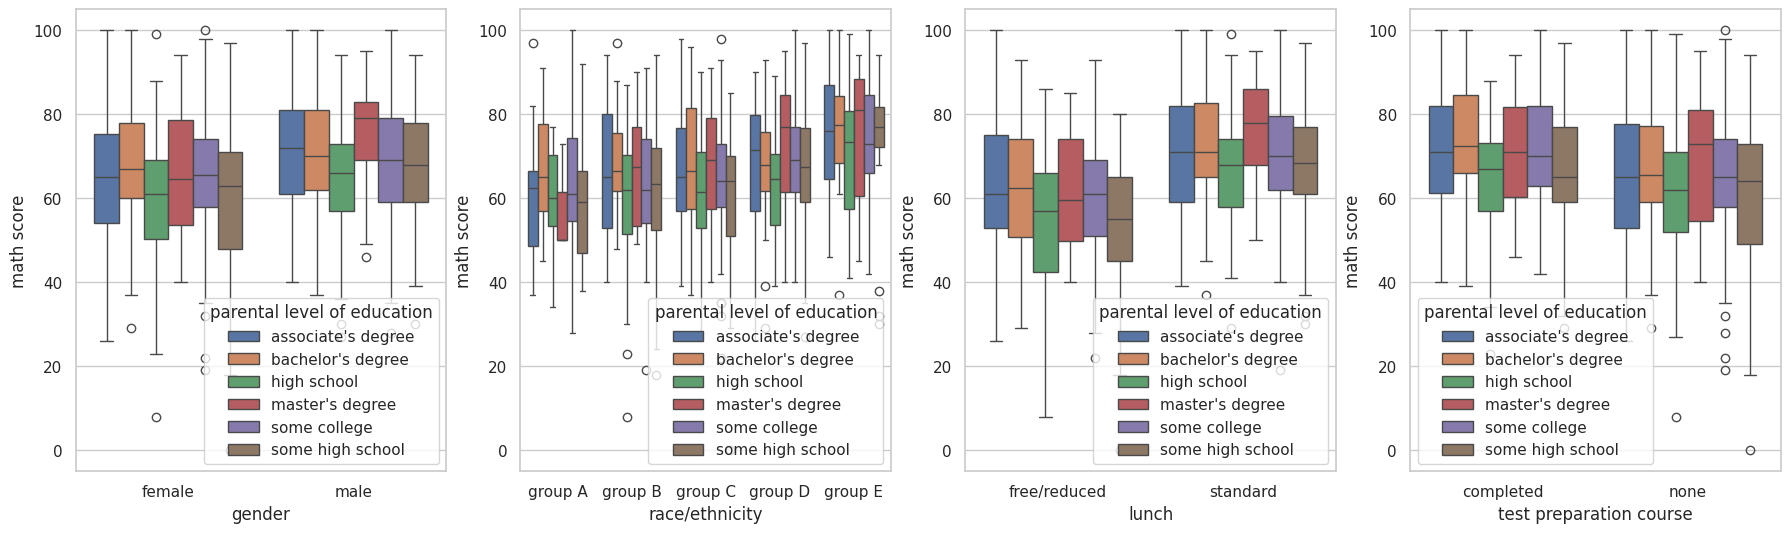

In [334]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize=(22, 6))
for i in range(4):
    sns.boxplot(df, x=nominal_var[i], y="math score", hue = "parental level of education" , ax = axs[i])

OK I can conclude that these features are very useless!

![](pic/anger-meme.jpg)

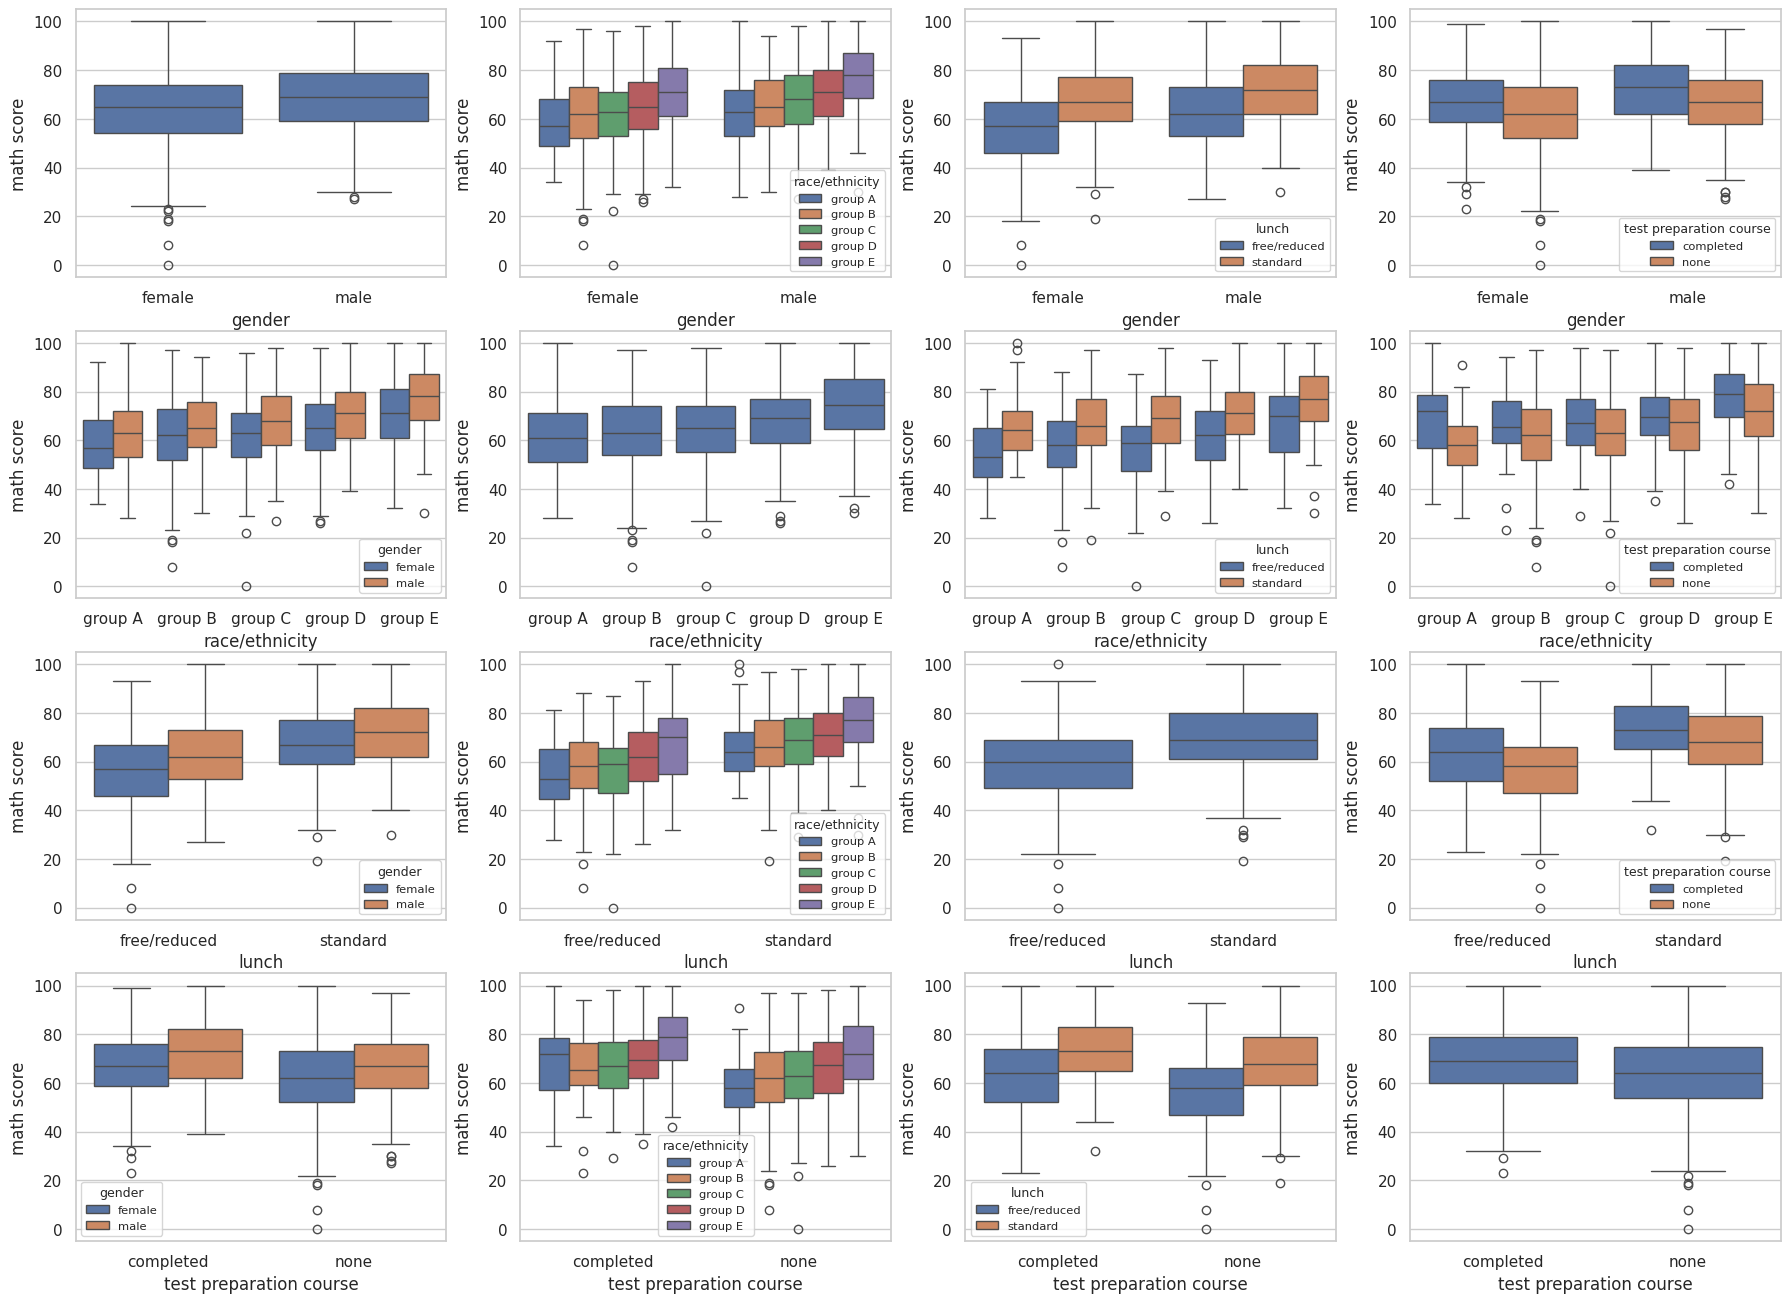

In [ ]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(22, 16))
for i in range(4):
    for j in range(4):
        if i == j:
            sns.boxplot(df, x=nominal_var[i], y="math score", ax = axs[i][j])
        else:
            with sns.plotting_context("notebook", font_scale=.75):
                sns.boxplot(df, x=nominal_var[i], y="math score", hue = nominal_var[j], ax = axs[i][j])

Pretty nice, Huh? Well I'm a Data Scientist, that's what I do for a living! 

Looks like, `ethnicity` and `lunch` have some sort of weak relation. I don't know let's add that interaction.


# Task 5

# Task 6

# Task 7

# Task 8